# Compare Color Levels Between Datasets

In [19]:
%load_ext chime
import geopandas as gpd
import rasterio as rio
import numpy as np
import os
from shapely.geometry import Point
import random

ortho15cmvrt_loc = r"D:/20191212_AZ_PIMA/2019_UrbanExtent_15cm/UGT_15cmOrtho_2019.vrt"
ortho30cmvrt_loc = os.path.abspath("../EPCExtent_30cm/Orthos/EPC_30cmOrtho_2019.vrt")

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


True

In [16]:
ugt_index = gpd.read_file(r"D:\20191212_AZ_PIMA\metadata\2019_hxip_tucson_az_z12_tiles.shp").to_crs("epsg:2868")
ugt_poly = ugt_index.unary_union
bnds = ugt_poly.bounds
points = []
with rio.open(ortho15cmvrt) as src:
    while len(points) < 100000:
        x = random.uniform(bnds[0], bnds[2])
        y = random.uniform(bnds[1], bnds[3])
        point = Point(x,y)
        if point.intersects(ugt_poly):
            points.append((x,y))

print("Created random sample points. Pulling Raster Values")

with rio.open(ortho15cmvrt_loc) as src:
    UGTvalues = [v for v in src.sample(points)]
print("Done with UGT")
with rio.open(ortho30cmvrt_loc) as src:
    EPCvalues = [v for v in src.sample(points)]
print("Done with EPC")
%chime
colorSamplePoints = gpd.GeoDataFrame({"UGTValues":UGTvalues, "EPCValues":EPCvalues}, geometry=[Point(point) for point in points], crs="epsg:2868")
                                               
def getValuesInOrtho(geom, ortho):
    x = geom.x
    y = geom.y
    
    with rio.open(ortho) as src:
        values = [v for v in src.sample([(x,y)])]
    return values[0]



#colorSamplePoints["UGT_values"] = colorSamplePoints["geometry"].apply(lambda g: getValuesInOrtho(g, ortho15cmvrt))

#colorSamplePoints["EPC_values"] = colorSamplePoints["geometry"].apply(lambda g: getValuesInOrtho(g, ortho30cmvrt_loc))


Created random sample points. Pulling Raster Values
Done with UGT


RasterioIOError: M:\EPCExtent_30cm\Orthos\EPC_30cmOrtho_2019.vrt: No such file or directory

In [29]:
chunksize = 10000
EPCvalues = []
for i in range (0,len(points),chunksize):
    print(i)
    sp = points[i:i+chunksize]
    with rio.open(ortho30cmvrt_loc) as src:
        EPCvalues += [v for v in src.sample(sp)]
print("Done with EPC")
%chime
colorSamplePoints = gpd.GeoDataFrame({"UGTValues":UGTvalues, "EPCValues":EPCvalues}, geometry=[Point(point) for point in points], crs="epsg:2868")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Done with EPC


NameError: name 'EPCValues' is not defined

In [33]:
colorSamplePoints = gpd.GeoDataFrame({"UGTValues":UGTvalues, "EPCValues":EPCvalues}, geometry=[Point(point) for point in points], crs="epsg:2868")

In [39]:
colorSamplePoints["UGTRed"] = colorSamplePoints["UGTValues"].apply(lambda v: v[0])
colorSamplePoints["UGTGreen"] = colorSamplePoints["UGTValues"].apply(lambda v: v[1])
colorSamplePoints["UGTBlue"] = colorSamplePoints["UGTValues"].apply(lambda v: v[2])
colorSamplePoints["UGTNIR"] = colorSamplePoints["UGTValues"].apply(lambda v: v[3])

colorSamplePoints["EPCRed"] = colorSamplePoints["EPCValues"].apply(lambda v: v[0])
colorSamplePoints["EPCGreen"] = colorSamplePoints["EPCValues"].apply(lambda v: v[1])
colorSamplePoints["EPCBlue"] = colorSamplePoints["EPCValues"].apply(lambda v: v[2])
colorSamplePoints["EPCNIR"] = colorSamplePoints["EPCValues"].apply(lambda v: v[3])

In [1]:
colorSamplePoints.to_file("../OtherData/ColorSamplePoints.gpkg", driver="GPKG")
colorSamplePoints.head()

NameError: name 'colorSamplePoints' is not defined

In [46]:
import pandas as pd

colorSamplePointsDF = pd.DataFrame(colorSamplePoints)

'UGTRed, UGTGreen, UGTBlue, UGTNIR, EPCRed, EPCGreen, EPCBlue, EPCNIR'

In [56]:
cols = ["UGTRed", "UGTGreen", "UGTBlue", "UGTNIR", "EPCRed", "EPCGreen", "EPCBlue", "EPCNIR"]
for col in cols:
    colorSamplePointsDF = colorSamplePointsDF[colorSamplePointsDF[col] != 0 ]

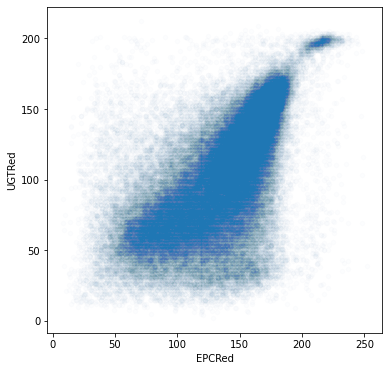

In [59]:
colorSamplePointsDF.plot.scatter(x="EPCRed", y="UGTRed", alpha=0.01, figsize=(6,6))

In [132]:
p(colorSamplePointsDF[cols[0]])

Polynomial([110.81474984,  48.64493973,  38.14471646], domain=[  1., 224.], window=[-1.,  1.])

In [122]:
nir = colorSamplePointsDF[cols[0]].values
red = colorSamplePointsDF[cols[1]].values
coefs = np.polynomial.polynomial.Polynomial.fit(x=nir, y=red, deg=2)
p = np.poly1d(coefs)

[ 3.06820700e-03 -2.54069088e-01  1.00565527e+02]


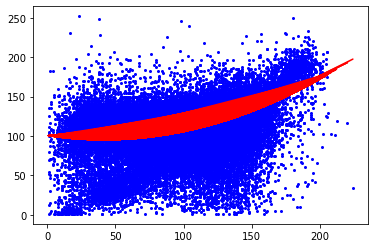

In [138]:
import numpy as np
from matplotlib import pyplot as plt
#X = np.linspace(0, 100, 50)
sub = colorSamplePointsDF[cols]
sub.sort_values(by=cols[0])
X = sub[cols[0]]
#Y = 23.24 + 2.2*X + 0.24*(X**2) + 10*np.random.randn(50) #added some noise
Y = sub[cols[1]]
coefs = np.polyfit(X, Y, 2)
print(coefs)
p = np.poly1d(coefs)
plt.plot(X, Y, "bo", markersize= 2)
plt.plot(X, p(X), "r-") #p(X) evaluates the polynomial at X
plt.show()

ValueError: x and y must have same first dimension, but have shapes (99723,) and (1,)

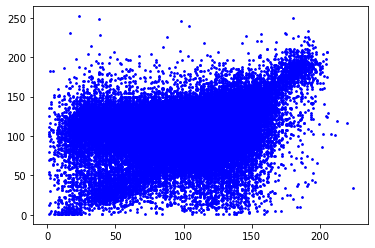

In [134]:
plt.plot(colorSamplePointsDF[cols[0]], colorSamplePointsDF[cols[1]], "bp", markersize= 2)
plt.plot(colorSamplePointsDF[cols[0]], p(colorSamplePointsDF[cols[1]]), "r-")

In [113]:
X = colorSamplePointsDF[cols].iloc[:,0:1]
Y = colorSamplePointsDF[cols].iloc[:,1]
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [117]:
X

,UGTNIR
0,128
1,77
2,144
3,109
4,142
...,...
99995,104
99996,63
99997,87
99998,101


['UGTRed', 'EPCRed']


['UGTGreen', 'EPCGreen']


['UGTBlue', 'EPCBlue']


['UGTNIR', 'EPCNIR']


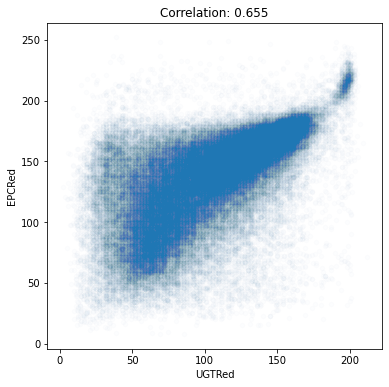

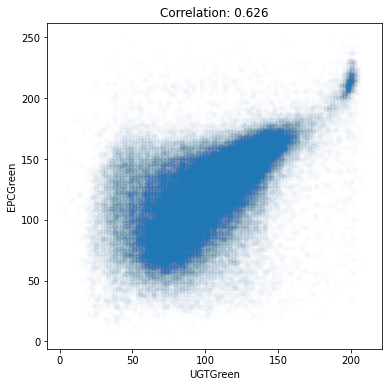

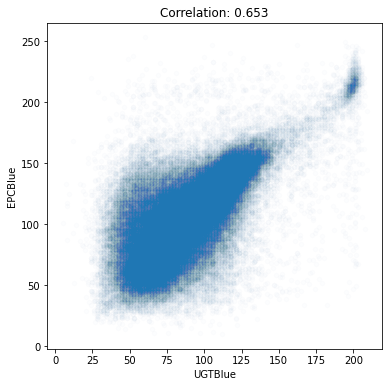

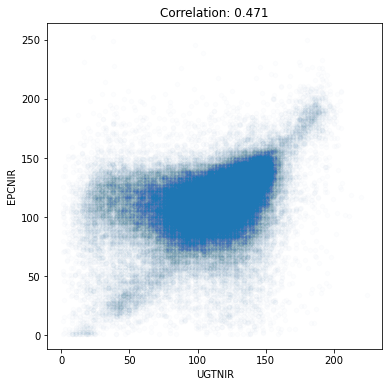

In [80]:
for band in ["Red","Green","Blue","NIR"]:
    cols = [col for col in colorSamplePointsDF.columns.tolist() if band.lower() in col.lower()]
    print(cols)

    correlation = colorSamplePointsDF[cols].corr(method="spearman")
    colorCorr = correlation[cols[0]].values.min()
    display(colorSamplePointsDF.plot.scatter(x=cols[0], y=cols[1], alpha=0.01, figsize=(6,6),title=f"Correlation: {round(colorCorr,3)}"))